# **Notebook 5: Regression with Original Untreated Dataset**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

## Change working directory

In [272]:
import os

# Get the current directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Change the directory to the new path
os.chdir('/workspace/milestone-project-housing-issues')

# Get the updated current directory
current_dir = os.getcwd()
print("New Current Directory:", current_dir)

Current Directory: /workspace/milestone-project-housing-issues
New Current Directory: /workspace/milestone-project-housing-issues


## Load dataset

In [273]:
# Loading original dataset from /workspace/milestone-project-housing-issues/inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv
# Drop EnclosedPorch and WoodDeckSF as we know they have more than 80% missing data

import pandas as pd
df_houseprices_regression = pd.read_csv('/workspace/milestone-project-housing-issues/inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv').drop(['EnclosedPorch', 'WoodDeckSF'], axis=1)
print(df_houseprices_regression.shape)
df_houseprices_regression.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


In [274]:
df_houseprices_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1374 non-null   float64
 2   BedroomAbvGr  1361 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1346 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1298 non-null   object 
 9   GarageYrBlt   1379 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1201 non-null   float64
 14  MasVnrArea    1452 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

---

## Checking Missing Data

In [275]:
#Using EvaluateMissingData() function to display missing data
def EvaluateMissingData(df_houseprices_regression):
  missing_data_absolute = df_houseprices_regression.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df_houseprices_regression)*100, 2)
  df_missing_data = (pd.DataFrame(
              data={"RowsWithMissingData": missing_data_absolute,
                  "PercentageOfDataset": missing_data_percentage,
                  "DataType": df_houseprices_regression.dtypes}
                  )
             .sort_values(by=['PercentageOfDataset'], ascending=False)
             .query("PercentageOfDataset > 0")
             )

  return df_missing_data

EvaluateMissingData(df_houseprices_regression)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


In [276]:
# Recode missing data as per Notebook 2 using random sampling from the distribution for LotFrontage, GarageFinish, BsmtFinType1, BedroomAbvGr, 2ndFlrSF, GarageYrBlt, MasVnrArea

import numpy as np

columns_to_impute = ['LotFrontage', 'GarageFinish', 'BsmtFinType1', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']

# Apply random sampling from the distribution for each specified column
for col in columns_to_impute:
    df_houseprices_regression[col] = df_houseprices_regression[col].apply(
        lambda x: np.random.choice(df_houseprices_regression[col].dropna()) if pd.isnull(x) else x
    )



In [277]:
df_houseprices_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

In [278]:
missing_values_count = df_houseprices_regression.isna().sum()
missing_values_count

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

---

## ML Pipeline: Regressor

### ML Pipeline

In [279]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    
    categorical_vars = X_train.select_dtypes(include=['object']).columns.tolist()

    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=categorical_vars)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection", SelectFromModel(model)),

        ("model", model),
    ])
    return pipeline_base

In [280]:
df_houseprices_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

### Hyperparameter Optimisation

In [281]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


### Split Train Test Set

In [282]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_houseprices_regression.drop(['SalePrice'], axis=1),
    df_houseprices_regression['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Grid Search CV - Sklearn

In [283]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [284]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

In [285]:
import numpy as np

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.804354,0.874444,0.07169
0,LinearRegression,0.715522,0.801388,0.840018,0.045926
5,GradientBoostingRegressor,0.635656,0.748619,0.831448,0.081483
4,AdaBoostRegressor,0.621051,0.740143,0.788661,0.060468
2,RandomForestRegressor,0.632989,0.729758,0.817394,0.07011
6,XGBRegressor,0.516199,0.637356,0.711843,0.072758
1,DecisionTreeRegressor,0.495511,0.575796,0.669601,0.064638


### Search for most suitable model to find the best hyperparameters

In [286]:
models_search_regressor = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search_regressor = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],  # Number of trees
        'model__max_depth': [3, 10, None],  # Maximum depth of each tree
        'model__min_samples_split': [2, 5],  # Minimum samples required to split a node
        'model__min_samples_leaf': [1, 4],  # Minimum samples required at a leaf node
        'model__max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
    }
}

params_quick_search_regressor = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],  # Number of trees
        'model__max_depth': [3, 10, None],  # Maximum depth of each tree
        'model__min_samples_split': [2, 5],  # Minimum samples required to split a node
        'model__min_samples_leaf': [1, 4],  # Minimum samples required at a leaf node
        'model__max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
    }
}


In [287]:
search = HyperparameterOptimizationSearch(models=models_search_regressor, params=params_search_regressor)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [288]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
39,ExtraTreesRegressor,0.773261,0.831803,0.875627,0.039258,None,auto,4,5,300
37,ExtraTreesRegressor,0.773261,0.831803,0.875627,0.039258,None,auto,4,2,300
38,ExtraTreesRegressor,0.770705,0.831688,0.878759,0.041045,None,auto,4,5,100
36,ExtraTreesRegressor,0.770705,0.831688,0.878759,0.041045,None,auto,4,2,100
23,ExtraTreesRegressor,0.771963,0.830523,0.875151,0.038402,10,auto,4,5,300
21,ExtraTreesRegressor,0.771963,0.830523,0.875151,0.038402,10,auto,4,2,300
20,ExtraTreesRegressor,0.770815,0.830442,0.876097,0.039479,10,auto,4,2,100
22,ExtraTreesRegressor,0.770815,0.830442,0.876097,0.039479,10,auto,4,5,100
43,ExtraTreesRegressor,0.724212,0.825335,0.880357,0.056302,None,sqrt,1,5,300
41,ExtraTreesRegressor,0.70908,0.82303,0.878834,0.060482,None,sqrt,1,2,300


---

### Best model and hyperparameters

In [289]:
best_model_regressor = grid_search_summary.iloc[0, 0]
best_model_regressor

'ExtraTreesRegressor'

In [290]:
best_params_regressor = grid_search_pipelines[best_model_regressor].best_params_
best_params_regressor

{'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 2,
 'model__n_estimators': 300}

#### Best regressor pipeline

In [291]:
best_regressor_pipeline = grid_search_pipelines[best_model_regressor].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFront

---

### Assessing feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea']


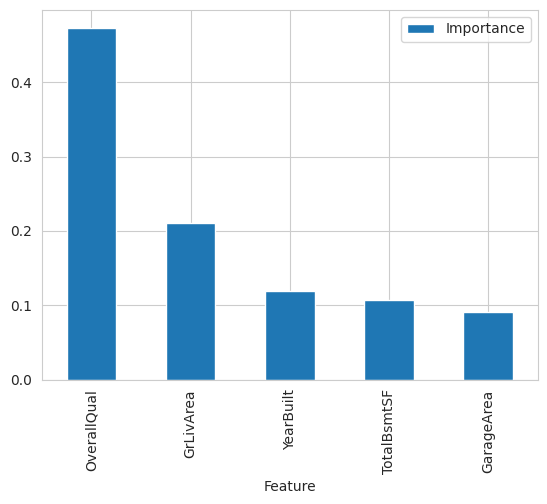

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


---

## Evaluate on Train and Test Sets

In [293]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.897
Mean Absolute Error: 15658.157
Mean Squared Error: 633206482.536
Root Mean Squared Error: 25163.594


* Test Set


R2 Score: 0.799
Mean Absolute Error: 20606.039
Mean Squared Error: 1391233259.205
Root Mean Squared Error: 37299.239




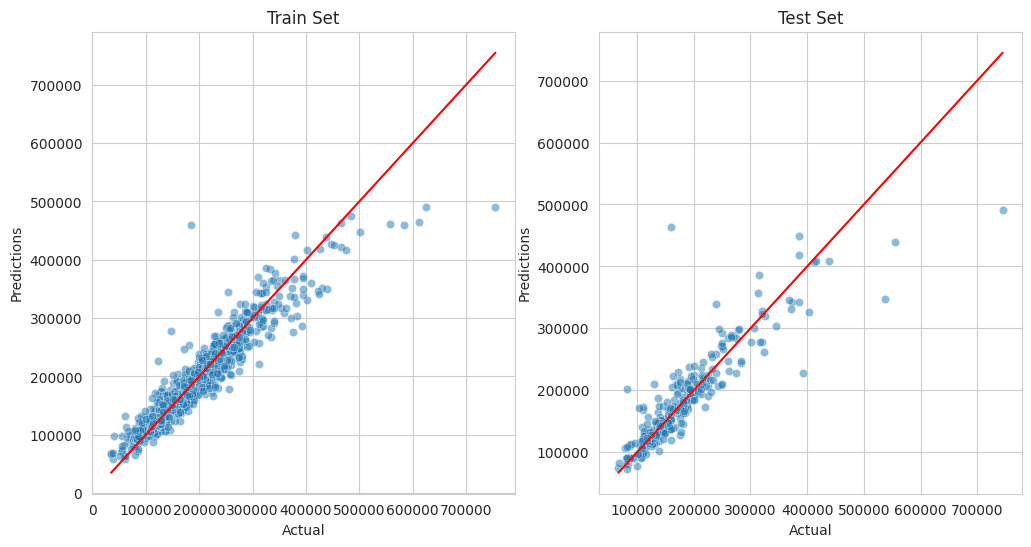

In [294]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

## Regressor with PCA

In [295]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df_houseprices_regression.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


#### Applying PCA to the scaled data

* The 17 components explain 100.0% of the data 



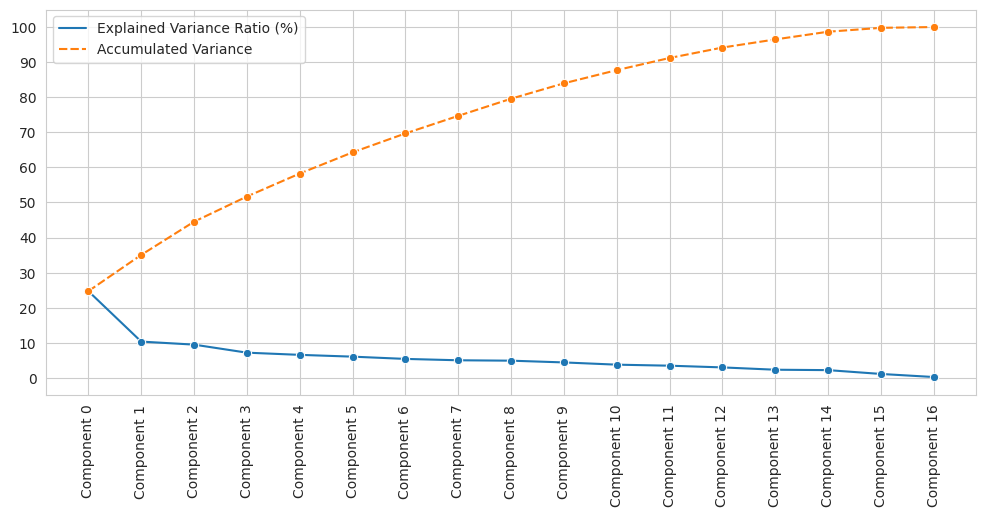

In [296]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 9 components explain 79.57% of the data 



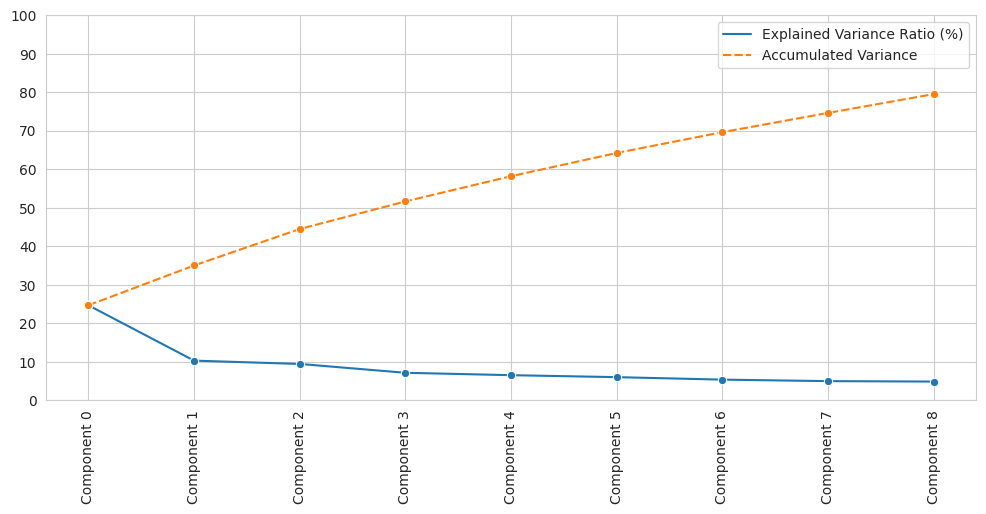

In [297]:
n_components = 9
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite ML Pipeline for Modelling

In [298]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1',
                                                                'GarageFinish', 'KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=9, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

In [299]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [300]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


In [301]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set a

In [302]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.737586,0.799358,0.846406,0.036487
3,ExtraTreesRegressor,0.665712,0.794725,0.851231,0.067312
0,LinearRegression,0.68008,0.788437,0.837747,0.055623
5,GradientBoostingRegressor,0.678152,0.782811,0.830202,0.056414
6,XGBRegressor,0.632524,0.769135,0.823295,0.069943
4,AdaBoostRegressor,0.665746,0.746953,0.77934,0.042354
1,DecisionTreeRegressor,0.566654,0.667989,0.718644,0.057261


### Extensive search on the most suitable model to find the best hyperparameters

In [303]:
models_search_pca = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search_pca = {
    "RandomForestRegressor":{
        'model__n_estimators': [100, 300],
        'model__max_depth': [3, 10, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 4],
        'model__max_features': ['auto', 'sqrt'],
    }
}

In [304]:
search = HyperparameterOptimizationSearch(models=models_search_pca, params=params_search_pca)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [305]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
37,RandomForestRegressor,0.755445,0.80417,0.856636,0.032899,None,auto,4,2,300
39,RandomForestRegressor,0.755445,0.80417,0.856636,0.032899,None,auto,4,5,300
23,RandomForestRegressor,0.755822,0.804041,0.856491,0.032696,10,auto,4,5,300
21,RandomForestRegressor,0.755822,0.804041,0.856491,0.032696,10,auto,4,2,300
41,RandomForestRegressor,0.757308,0.803683,0.834774,0.028297,None,sqrt,1,2,300
35,RandomForestRegressor,0.742933,0.803235,0.847628,0.034523,None,auto,1,5,300
33,RandomForestRegressor,0.741425,0.803013,0.849284,0.035664,None,auto,1,2,300
20,RandomForestRegressor,0.756343,0.802961,0.853026,0.031956,10,auto,4,2,100
22,RandomForestRegressor,0.756343,0.802961,0.853026,0.031956,10,auto,4,5,100
38,RandomForestRegressor,0.755366,0.802875,0.85288,0.032225,None,auto,4,5,100


### Best model and hyperparameters:

In [306]:
best_model_pca = grid_search_summary.iloc[0,0]
best_model_pca

'RandomForestRegressor'

In [307]:
best_params_pca = grid_search_pipelines[best_model_pca].best_params_
best_params_pca

{'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 2,
 'model__n_estimators': 300}

In [308]:
best_regressor_pca_pipeline = grid_search_pipelines[best_model_pca].best_estimator_
best_regressor_pca_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLi

## Evaluating Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.897
Mean Absolute Error: 15658.157
Mean Squared Error: 633206482.536
Root Mean Squared Error: 25163.594


* Test Set
R2 Score: 0.799
Mean Absolute Error: 20606.039
Mean Squared Error: 1391233259.205
Root Mean Squared Error: 37299.239




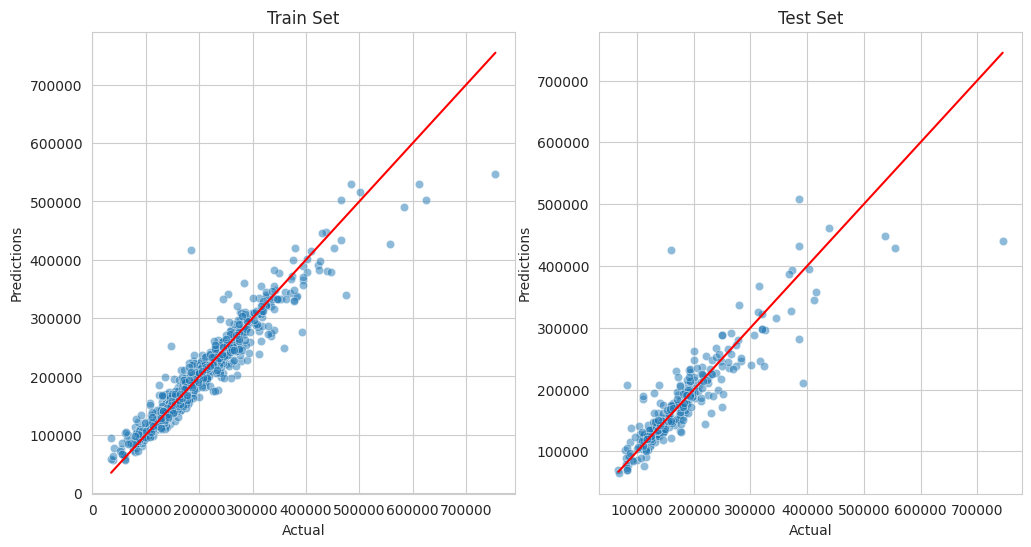

In [309]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pca_pipeline)

---

# Convert Regression to Classification

* The classes represent the following ranges: 
{'SalePrice': [-inf, 129975.0, 163000.0, 214000.0, inf]} 



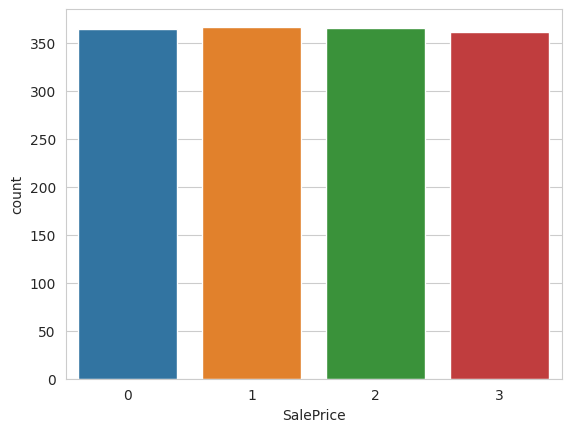

In [310]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=4, variables=['SalePrice'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df_houseprices_regression)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='SalePrice')
plt.show()

In [311]:
df_clf.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,2
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,2
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,3


### Rewriting ML Pipeline for modelling

In [312]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1',
                                                                'GarageFinish', 'KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

#### Algorithms for classification

In [313]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

### Splitting Train and Test Sets

In [314]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Grid Seach CV – Sklearn

In [315]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [316]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [317]:
# from sklearn.metrics import make_scorer, recall_score
# quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
# quick_search.fit(X_train, y_train,
#                  scoring = make_scorer(recall_score, labels=[0], average=None),
#                  n_jobs=-1,
#                  cv=5)

In [318]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.737586,0.799358,0.846406,0.036487
3,ExtraTreesRegressor,0.665712,0.794725,0.851231,0.067312
0,LinearRegression,0.68008,0.788437,0.837747,0.055623
5,GradientBoostingRegressor,0.678152,0.782811,0.830202,0.056414
6,XGBRegressor,0.632524,0.769135,0.823295,0.069943
4,AdaBoostRegressor,0.665746,0.746953,0.77934,0.042354
1,DecisionTreeRegressor,0.566654,0.667989,0.718644,0.057261


### Extensive search on hyperparameters

In [319]:
models_search_clf = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search_clf = {
    "GradientBoostingClassifier":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

In [320]:
search = HyperparameterOptimizationSearch(models=models_search_clf, params=params_search_clf)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [321]:
# from sklearn.metrics import make_scorer,  recall_score
# search = HyperparameterOptimizationSearch(
#     models=models_search_clf, params=params_search_clf)
# search.fit(X_train, y_train,
#            scoring=make_scorer(recall_score, labels=[0], average=None),
#            n_jobs=-1, cv=5)

In [322]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingClassifier,0.729682,0.747917,0.762306,0.011729,0.1,3,100
1,GradientBoostingClassifier,0.661248,0.732871,0.775888,0.038091,0.1,3,300
7,GradientBoostingClassifier,0.684192,0.730248,0.769097,0.027101,0.01,3,300
3,GradientBoostingClassifier,0.711358,0.729538,0.752119,0.014864,0.1,10,300
2,GradientBoostingClassifier,0.671513,0.717246,0.752119,0.032033,0.1,10,100
6,GradientBoostingClassifier,0.660436,0.683963,0.726261,0.022846,0.01,3,100
9,GradientBoostingClassifier,0.640717,0.681759,0.73514,0.042411,0.01,10,300
13,GradientBoostingClassifier,0.599315,0.643701,0.70458,0.034914,0.001,3,300
8,GradientBoostingClassifier,0.585714,0.628666,0.724954,0.049868,0.01,10,100
12,GradientBoostingClassifier,0.579126,0.609645,0.653645,0.027531,0.001,3,100


### Best model and hyperparameters

In [323]:
best_model_clf = grid_search_summary.iloc[0,0]
best_model_clf

'GradientBoostingClassifier'

In [324]:
best_params_clf = grid_search_pipelines[best_model_clf].best_params_
best_params_clf

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

In [325]:
pipeline_clf = grid_search_pipelines[best_model_clf].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'Lot

---

### Assessing feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'LotArea']


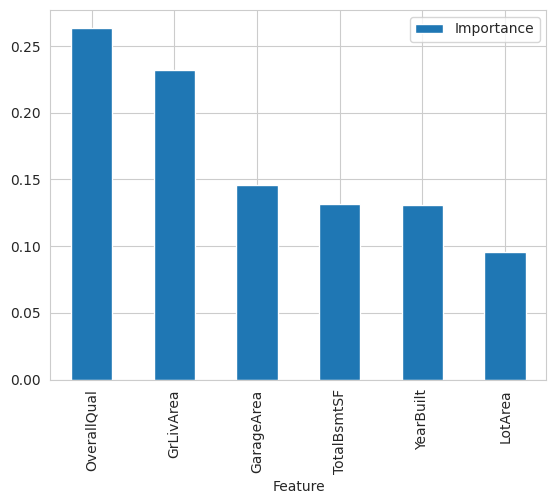

In [326]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


---

## Evaluate classifier on train and test sets

In [327]:
# from sklearn.metrics import classification_report, confusion_matrix


# def confusion_matrix_and_report(X, y, pipeline, label_map):

#     prediction = pipeline.predict(X)

#     print('---  Confusion Matrix  ---')
#     print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
#           columns=[["Actual " + sub for sub in label_map]],
#           index=[["Prediction " + sub for sub in label_map]]
#           ))
#     print("\n")

#     print('---  Classification Report  ---')
#     print(classification_report(y, prediction, target_names=label_map), "\n")


# def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
#     print("#### Train Set #### \n")
#     confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

#     print("#### Test Set ####\n")
#     confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [328]:
# disc.binner_dict_['SalePrice']

In [329]:
# label_map = ['129,975 and under', '129,975 to 163,000', '163,000 to 214,000', '214,000 and over']
# label_map

Model Evaluation 

* Train Set
R2 Score: 0.939
Mean Absolute Error: 0.07
Mean Squared Error: 0.077
Root Mean Squared Error: 0.278


* Test Set
R2 Score: 0.698
Mean Absolute Error: 0.295
Mean Squared Error: 0.363
Root Mean Squared Error: 0.603




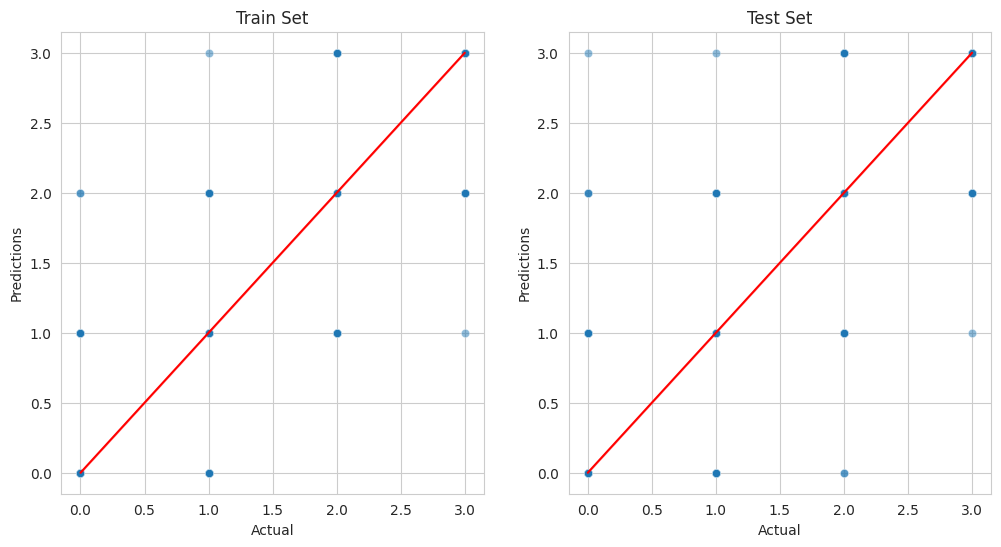

In [330]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_clf)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            pipeline_clf)

---

# Identifying which pipeline to choose?

We fitted 3 pipelines fitted:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [331]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFront

---

## Refit pipeline with best features

### Rewrite Pipeline

In [332]:
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def PipelineOptimization(model):

    categorical_features = ['OverallQual'] 
    numerical_features = ['GrLivArea', 'GarageArea', 'YearBuilt', 'TotalBsmtSF', 'LotArea']

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OrdinalEncoder(encoding_method='arbitrary'), categorical_features),
            ("num", StandardScaler(), numerical_features)
        ]
    )

    pipeline_base = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model),
    ])

    return pipeline_base

In [333]:
df_houseprices_best_model = df_houseprices_regression[['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'LotArea', 'SalePrice']]
df_houseprices_best_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   GrLivArea    1460 non-null   int64
 2   GarageArea   1460 non-null   int64
 3   TotalBsmtSF  1460 non-null   int64
 4   YearBuilt    1460 non-null   int64
 5   LotArea      1460 non-null   int64
 6   SalePrice    1460 non-null   int64
dtypes: int64(7)
memory usage: 80.0 KB


### Split Train and Test Sets

In [334]:
X_train, X_test, y_train, y_test = train_test_split(
    df_houseprices_best_model.drop(['SalePrice'], axis=1),
    df_houseprices_best_model['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 6) (1168,) 
* Test set: (292, 6) (292,)


In [335]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 6) (1168,) 
* Test set: (292, 6) (292,)


,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,LotArea
618,9,1828,774,1822,2007,11694
870,5,894,308,894,1962,6600
92,5,964,432,876,1921,13360


In [336]:
X_test.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,LotArea
529,6,2515,484,2035,1957,32668
491,6,1578,240,806,1941,9490
459,5,1203,352,709,1950,7015
279,7,2022,505,1160,1977,10005
655,6,1092,264,525,1971,1680


In [337]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1168 non-null   int64
 1   GrLivArea    1168 non-null   int64
 2   GarageArea   1168 non-null   int64
 3   TotalBsmtSF  1168 non-null   int64
 4   YearBuilt    1168 non-null   int64
 5   LotArea      1168 non-null   int64
dtypes: int64(6)
memory usage: 63.9 KB


### Grid Search CV – Sklearn

In [338]:
models_search_regressor

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [339]:
params_search = {'ExtraTreesRegressor':  {
    'model__n_estimators': [100, 300],
    'model__max_depth': [3, 10, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 4],
    'model__max_features': ['auto', 'sqrt'],
}
}
params_search

{'ExtraTreesRegressor': {'model__n_estimators': [100, 300],
  'model__max_depth': [3, 10, None],
  'model__min_samples_split': [2, 5],
  'model__min_samples_leaf': [1, 4],
  'model__max_features': ['auto', 'sqrt']}}

In [340]:
# Checking data types of best features
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1168 non-null   int64
 1   GrLivArea    1168 non-null   int64
 2   GarageArea   1168 non-null   int64
 3   TotalBsmtSF  1168 non-null   int64
 4   YearBuilt    1168 non-null   int64
 5   LotArea      1168 non-null   int64
dtypes: int64(6)
memory usage: 63.9 KB


In [341]:
# Recoded HyperparameterOptimizationSearch function for numerical variables
class HyperparameterOptimizationSearch_numerical:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization_numerical(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


In [342]:
# Recoded PipelineOptimization function for numerical variables

def PipelineOptimization_numerical(model):

    pipeline_base = Pipeline([

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', 'TotalBsmtSF', 'LotArea'],
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        # ("feat_selection", SelectFromModel(model)),

        ("model", model),
    ])
    return pipeline_base

In [343]:
from sklearn.metrics import make_scorer, r2_score
import numpy as np

search = HyperparameterOptimizationSearch_numerical(models=models_search_regressor, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(r2_score),
           n_jobs=-1, cv=5)
best_regressor_pipeline = search.grid_searches['ExtraTreesRegressor'].best_estimator_




Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Model Evaluation 

* Train Set
R2 Score: 0.964
Mean Absolute Error: 9305.733
Mean Squared Error: 219415071.886
Root Mean Squared Error: 14812.666


* Test Set
R2 Score: 0.811
Mean Absolute Error: 22012.021
Mean Squared Error: 1305582643.59
Root Mean Squared Error: 36132.847




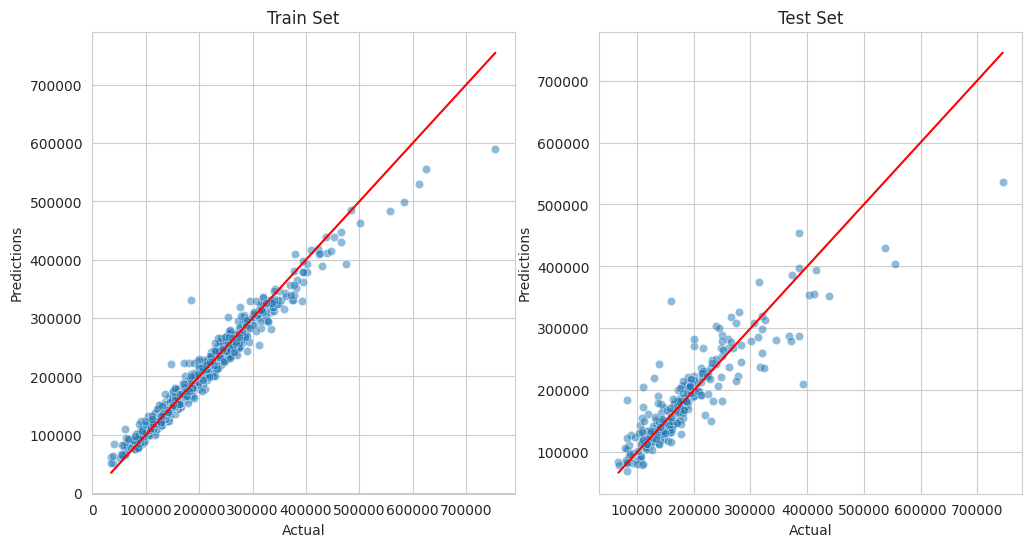

In [344]:
# Evaluating performance

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

In [345]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
43,ExtraTreesRegressor,0.708959,0.804372,0.876598,0.059035,None,sqrt,1,5,300
37,ExtraTreesRegressor,0.754081,0.804155,0.870111,0.046277,None,auto,4,2,300
39,ExtraTreesRegressor,0.754081,0.804155,0.870111,0.046277,None,auto,4,5,300
21,ExtraTreesRegressor,0.749673,0.80253,0.871134,0.047528,10,auto,4,2,300
23,ExtraTreesRegressor,0.749673,0.80253,0.871134,0.047528,10,auto,4,5,300
42,ExtraTreesRegressor,0.693192,0.802063,0.876143,0.063017,None,sqrt,1,5,100
20,ExtraTreesRegressor,0.752569,0.801947,0.869098,0.046604,10,auto,4,2,100
22,ExtraTreesRegressor,0.752569,0.801947,0.869098,0.046604,10,auto,4,5,100
41,ExtraTreesRegressor,0.693959,0.801934,0.874684,0.063312,None,sqrt,1,2,300
36,ExtraTreesRegressor,0.745055,0.801672,0.868371,0.048142,None,auto,4,2,100


In [346]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [347]:
pipeline_best = grid_search_pipelines[best_model].best_estimator_
pipeline_best

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['OverallQual', 'GrLivArea',
                                                     'GarageArea', 'YearBuilt',
                                                     'TotalBsmtSF',
                                                     'LotArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_split=5,
                                     n_estimators=300, random_state=0))])

---

### Assessing feature importance for best features model

* These are the 5 most important features in descending order. The model was trained on them: 
['GrLivArea', 'GarageArea', 'YearBuilt', 'TotalBsmtSF', 'LotArea']


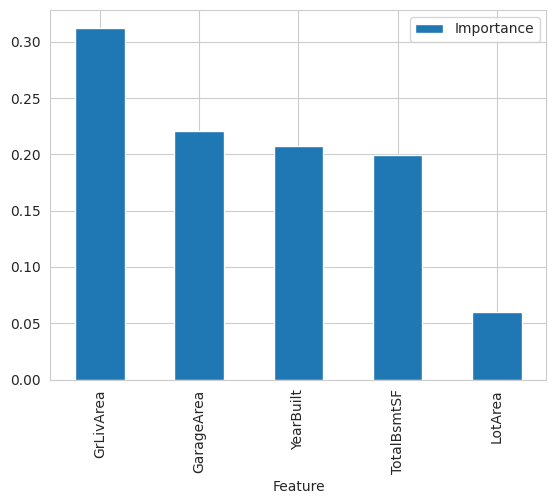

In [348]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_best.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_best['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

---

### Evaluate model with best features on train and test sets

In [349]:
regression_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_best)

Model Evaluation 

* Train Set
R2 Score: 0.964
Mean Absolute Error: 9305.733
Mean Squared Error: 219415071.886
Root Mean Squared Error: 14812.666


* Test Set
R2 Score: 0.811
Mean Absolute Error: 22012.021
Mean Squared Error: 1305582643.59
Root Mean Squared Error: 36132.847




---

## Pushing files to repo

In [350]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/regression_analysis/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/regression_analysis/v1'


### Train Set: features and target

In [351]:
X_train.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,LotArea
618,9,1828,774,1822,2007,11694
870,5,894,308,894,1962,6600
92,5,964,432,876,1921,13360
817,8,1689,857,1568,2002,13265
302,7,1541,843,1541,2001,13704


In [352]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [353]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [354]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: features and target

In [355]:
X_test.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,LotArea
529,6,2515,484,2035,1957,32668
491,6,1578,240,806,1941,9490
459,5,1203,352,709,1950,7015
279,7,2022,505,1160,1977,10005
655,6,1092,264,525,1971,1680


In [356]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [357]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [358]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Saving dataset with best features for best model use

In [364]:
df_houseprices_best_model.to_csv("/workspace/milestone-project-housing-issues/outputs/datasets/final/HousePricesBestModel.csv", index=False)

### Modelling pipeline

In [359]:
pipeline_best

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['OverallQual', 'GrLivArea',
                                                     'GarageArea', 'YearBuilt',
                                                     'TotalBsmtSF',
                                                     'LotArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_split=5,
                                     n_estimators=300, random_state=0))])

In [362]:
joblib.dump(value=pipeline_best, filename=f"{file_path}/pipeline_best.pkl")

['outputs/ml_pipeline/regression_analysis/v1/pipeline_best.pkl']

## Feature importance plot

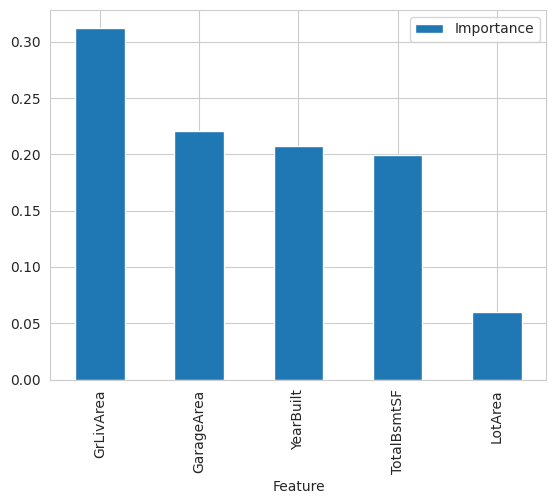

In [361]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---